In [1]:
import pandas as pd
import numpy as np
GBQ_PROJECT_ID = '620265099307'

import datetime
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib import verbose
#verbose.level = 'helpful'      # one of silent, helpful, debug, debug-annoying

# taken from https://github.com/jrmontag/STLDecompose
# requires installation - pip install stldecompose
from stldecompose import decompose
# Simpler smoothing uses:
# from statsmodels.tsa.seasonal import seasonal_decompose

import geopandas as gpd

# Overall prescribing

## Import data

In [38]:
#note for brian in sql bnf_code 1, 4  = 0801.....4 = the cutoff
q = '''
SELECT
  p.practice,
  AVG(total_list_size) AS list_size,
  pct,
  prac.setting,
  p.month,
  SUM(IF(SUBSTR(p.bnf_code,1,13)='1001030U0AAAB',
      items,
      0)) AS mtx_2_5,
  SUM(IF(SUBSTR(p.bnf_code,1,13)='1001030U0AAAC',
      items,
      0)) AS mtx_10,
  SUM(IF(SUBSTR(p.bnf_code,1,13)='1001030U0AACF'
      OR SUBSTR(p.bnf_code,1,13)='1001030U0AABT'
      OR SUBSTR(p.bnf_code,1,13)='1001030U0AABU',
      items,
      0)) AS mtx_liq,
  SUM(IF(SUBSTR(p.bnf_code,1,13)='1001030U0AAAH'
  OR SUBSTR(p.bnf_code,1,13)='1001030U0AAAK'
  OR SUBSTR(p.bnf_code,1,13)='1001030U0AAAS'
  OR SUBSTR(p.bnf_code,1,13)='1001030U0AAAR'
  OR SUBSTR(p.bnf_code,1,13)='1001030U0AAAT'
  OR SUBSTR(p.bnf_code,1,13)='1001030U0AAAV'
  OR SUBSTR(p.bnf_code,1,13)='1001030U0AAAE'
  OR SUBSTR(p.bnf_code,1,13)='1001030U0AAAA'
  OR SUBSTR(p.bnf_code,1,13)='1001030U0AAAF'
  OR SUBSTR(p.bnf_code,1,13)='1001030U0AAAI'
  OR SUBSTR(p.bnf_code,1,13)='1001030U0AAAM',
  items,
  0)) AS mtx_liqspec,
  SUM(IF((SUBSTR(p.bnf_code,1,12)='1001030U0AAB'
      OR SUBSTR(p.bnf_code,1,12)='1001030U0AAC'
      OR SUBSTR(p.bnf_code,1,13)='1001030U0AAAZ'
      OR SUBSTR(p.bnf_code,1,8)='0801030P') AND (SUBSTR(p.bnf_code,1,13)!='1001030U0AACF'
      OR SUBSTR(p.bnf_code,1,13)!='1001030U0AABT'
      OR SUBSTR(p.bnf_code,1,13)!='1001030U0AABU'),
      items,
      0)) AS mtx_inj,
  SUM(items) AS total_mtxitems
  FROM
    ebmdatalab.brian.methotrexate_subset_normalisedpresc AS p
  INNER JOIN
    ebmdatalab.hscic.practices prac
  ON
    p.practice = prac.code
    AND (prac.setting = 4
      OR prac.setting = 2)
  LEFT JOIN
    ebmdatalab.hscic.practice_statistics_all_years AS stat
  ON
    p.practice = stat.practice
    AND p.month = stat.month
  LEFT JOIN
    ebmdatalab.hscic.presentation r
  ON
    p.bnf_code = r.bnf_code
  GROUP BY
    practice, pct, setting, month
  ORDER BY
    practice, month
'''

all_mtx = pd.read_gbq(q, GBQ_PROJECT_ID, verbose=False, dialect='standard')
ooh_mtx = all_mtx.loc[all_mtx.setting==2]
gp_mtx = all_mtx.loc[all_mtx.setting==4]
all_mtx.info()

C:\Users\bmackenna\Anaconda3\lib\site-packages\pandas_gbq\gbq.py:556: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  "verbosity", FutureWarning, stacklevel=1)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707686 entries, 0 to 707685
Data columns (total 11 columns):
practice          707686 non-null object
list_size         689661 non-null float64
pct               707686 non-null object
setting           707686 non-null int64
month             707686 non-null datetime64[ns]
mtx_2_5           707686 non-null int64
mtx_10            707686 non-null int64
mtx_liq           707686 non-null int64
mtx_liqspec       707686 non-null int64
mtx_inj           707686 non-null int64
total_mtxitems    707686 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(7), object(2)
memory usage: 59.4+ MB


In [39]:
gp_mtx

,practice,list_size,pct,setting,month,mtx_2_5,mtx_10,mtx_liq,mtx_liqspec,mtx_inj,total_mtxitems
0,A81001,NaN,00K,4,2010-08-01,1,0,0,0,0,1
1,A81001,NaN,00K,4,2010-09-01,2,0,0,0,0,2
2,A81001,4241.0,00K,4,2010-10-01,2,0,0,0,0,2
3,A81001,4241.0,00K,4,2010-11-01,2,0,0,0,0,2
4,A81001,4241.0,00K,4,2010-12-01,2,0,0,0,0,2
5,A81001,4217.0,00K,4,2011-01-01,3,0,0,0,0,3
6,A81001,4217.0,00K,4,2011-02-01,1,0,0,0,0,1
7,A81001,4217.0,00K,4,2011-03-01,3,0,0,0,0,3
8,A81001,4186.0,00K,4,2011-04-01,2,0,0,0,0,2
9,A81001,4186.0,00K,4,2011-05-01,2,0,0,0,0,2


In [40]:
pc = gp_mtx.copy()

pc["2.5mg tabs"] = 100*(pc.mtx_2_5/pc.total_mtxitems).fillna(0)
pc["10mg tabs"] = 100*(pc.mtx_10/pc.total_mtxitems).fillna(0)
pc["liquid"] = 100*(pc.mtx_liq/pc.total_mtxitems).fillna(0)
pc["liquid specials"] = 100*(pc.mtx_liqspec/pc.total_mtxitems).fillna(0)
pc["injections"] = 100*(pc.mtx_inj/pc.total_mtxitems).fillna(0)

pc.head()

,practice,list_size,pct,setting,month,mtx_2_5,mtx_10,mtx_liq,mtx_liqspec,mtx_inj,total_mtxitems,2.5mg tabs,10mg tabs,liquid,liquid specials,injections
0,A81001,NaN,00K,4,2010-08-01,1,0,0,0,0,1,100.0,0.0,0.0,0.0,0.0
1,A81001,NaN,00K,4,2010-09-01,2,0,0,0,0,2,100.0,0.0,0.0,0.0,0.0
2,A81001,4241.0,00K,4,2010-10-01,2,0,0,0,0,2,100.0,0.0,0.0,0.0,0.0
3,A81001,4241.0,00K,4,2010-11-01,2,0,0,0,0,2,100.0,0.0,0.0,0.0,0.0
4,A81001,4241.0,00K,4,2010-12-01,2,0,0,0,0,2,100.0,0.0,0.0,0.0,0.0


In [41]:
pc.practice.drop_duplicates().count()

8109

### Calculations and percentiles

In [42]:
# filter for normal practices
filtered = pc.copy().loc[(pc.list_size>1000) & (pc["month"]>"2010-09-01") ]
filtered.head()

x1 = np.arange(0.1, 1, 0.1)
x2 = np.arange(0.01,0.1,0.01)
x3 = np.arange(0.91, 1, 0.01)
x = np.concatenate((x1,x2,x3))

#filtered tables grouped by months
pcf = filtered.groupby('month').quantile(x)

#putting groupby(month) from index back into being a column
pcf = pcf.reset_index().rename(columns={"level_1": 'percentile'})
pcf

,month,percentile,10mg tabs,2.5mg tabs,injections,liquid,liquid specials,list_size,mtx_10,mtx_2_5,mtx_inj,mtx_liq,mtx_liqspec,setting,total_mtxitems
0,2010-10-01,0.10,0.000000,61.272401,0.000000,0.0,0.0,2462.00,0.0,3.00,0.0,0.0,0.0,4.0,3.00
1,2010-10-01,0.20,0.000000,75.000000,0.000000,0.0,0.0,3306.60,0.0,5.00,0.0,0.0,0.0,4.0,6.00
2,2010-10-01,0.30,0.000000,85.714286,0.000000,0.0,0.0,4177.70,0.0,7.00,0.0,0.0,0.0,4.0,8.00
3,2010-10-01,0.40,0.000000,92.307692,0.000000,0.0,0.0,5187.00,0.0,9.00,0.0,0.0,0.0,4.0,11.00
4,2010-10-01,0.50,0.000000,97.142857,0.000000,0.0,0.0,6206.50,0.0,12.00,0.0,0.0,0.0,4.0,14.00
5,2010-10-01,0.60,0.000000,100.000000,0.000000,0.0,0.0,7352.00,0.0,15.00,0.0,0.0,0.0,4.0,17.00
6,2010-10-01,0.70,7.692308,100.000000,0.000000,0.0,0.0,8678.00,1.0,19.00,0.0,0.0,0.0,4.0,22.00
7,2010-10-01,0.80,18.181818,100.000000,0.000000,0.0,0.0,10239.20,2.0,24.00,0.0,0.0,0.0,4.0,27.00
8,2010-10-01,0.90,33.333333,100.000000,4.545455,0.0,0.0,12446.10,4.0,32.00,1.0,0.0,0.0,4.0,36.00
9,2010-10-01,0.01,0.000000,20.000000,0.000000,0.0,0.0,1551.37,0.0,1.00,0.0,0.0,0.0,4.0,1.00


In [43]:
filtered.practice.drop_duplicates().count()

8045

## Practice level plots

### Without smoothing

C:\Users\bmackenna\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


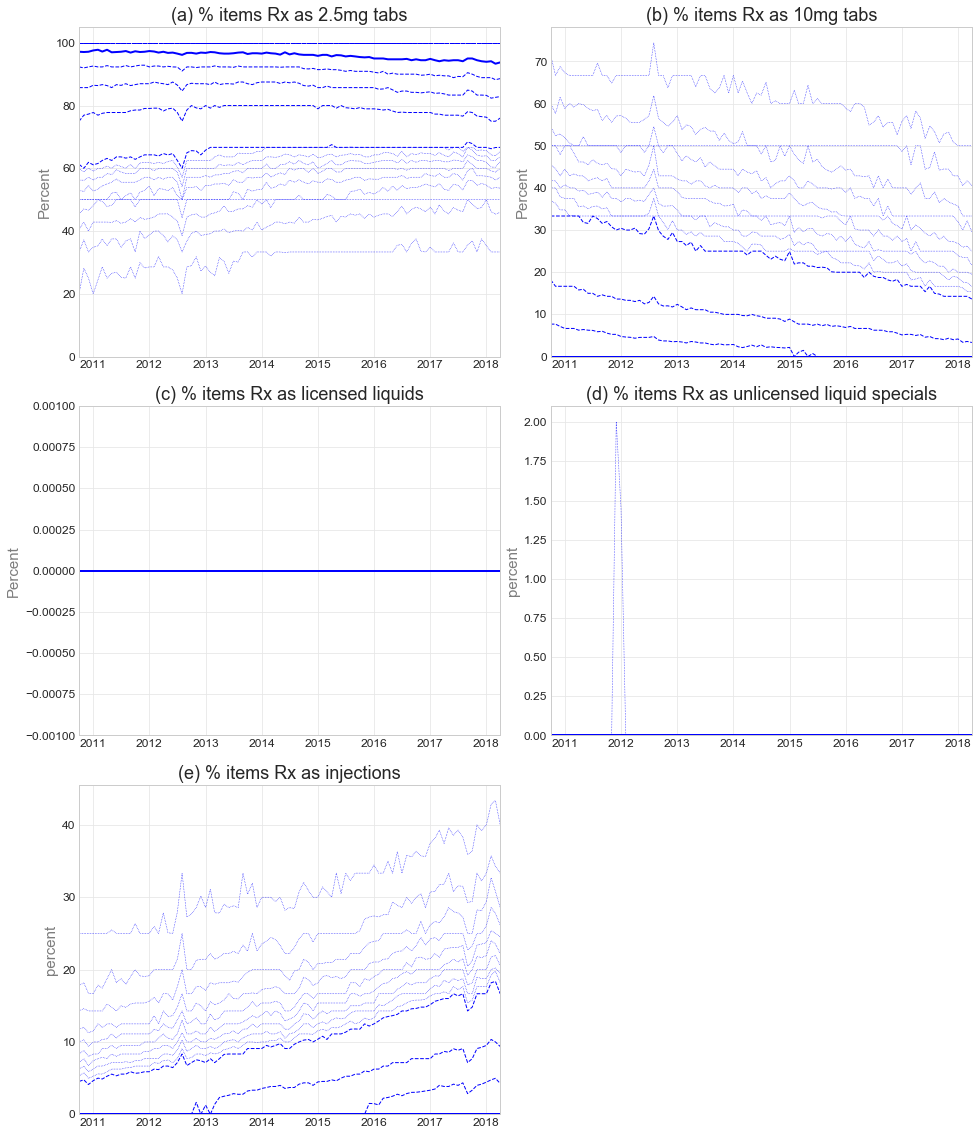

In [44]:
sns.set_style("whitegrid",{'grid.color': '.9'})
dfp = pcf.copy().sort_values(by=["month"])#,"drug"])
dfp['month'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month']]

# set sort order of drugs manually, and add grid refs to position each subplot:
# order is column, title, axis
s = [(0,'2.5mg tabs',0,0,'(a) % items Rx as 2.5mg tabs','Percent'), 
     (1,'10mg tabs',0,1,'(b) % items Rx as 10mg tabs','Percent'),
     (2,'liquid',1,0,'(c) % items Rx as licensed liquids','Percent'),
     (3,'liquid specials',1,1, '(d) % items Rx as unlicensed liquid specials', 'percent'),
     (4,'injections',2,0, '(e) % items Rx as injections', 'percent')]


x = pd.Series(x)
fig = plt.figure(figsize=(16,20)) 
gs = gridspec.GridSpec(3,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    for decile in x:   # plot each decile line
        data = dfp.loc[(dfp['percentile']==decile)]#(dfp['drug']==i[1]) & 
        if decile == .5:
            ax.plot(data["dates"],data[i[1]],'b-',linewidth=2)
        elif (decile <0.1) | (decile >0.9):
            ax.plot(data["dates"],data[i[1]],'b:',linewidth=0.6)
        else:
            ax.plot(data["dates"],data[i[1]],'b--',linewidth=1)
    ax.set_ylabel(i[5], size =15, alpha=0.6)
    ax.set_title(i[4],size = 18)
    ax.set_ylim([0, dfp[i[1]].max()*1.05])  # set ymax across all subplots as largest value across dataset
    ax.tick_params(labelsize=12)
    ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range

plt.subplots_adjust(wspace = 0.12,hspace = 0.15)
plt.savefig('practice_deciles_no_smooth.png', format='png', dpi=300,bbox_inches='tight')
plt.show()

### Graphs above - absolute numbers of items in raph c and d are below 80 most months


### WIth smoothing

C:\Users\bmackenna\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))
C:\Users\bmackenna\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


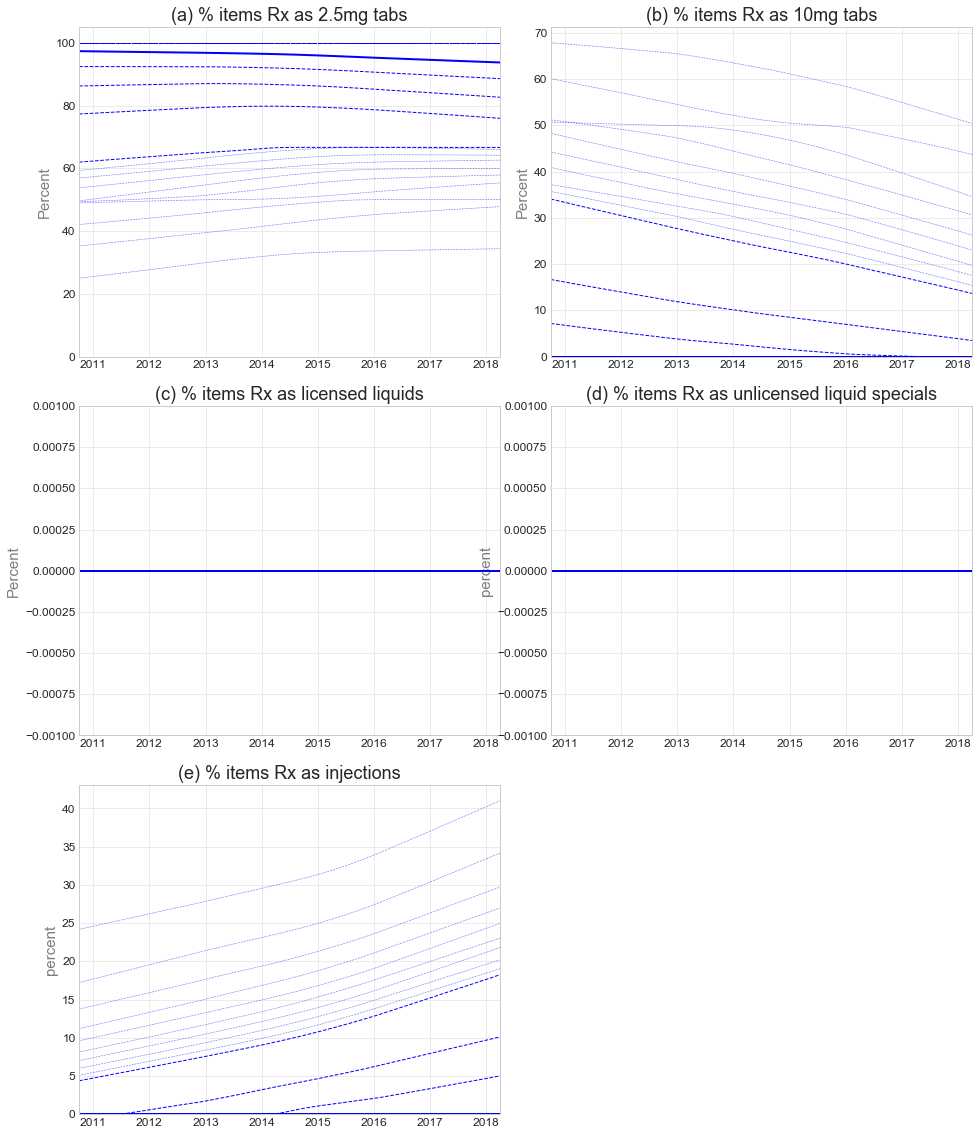

In [45]:
sns.set_style("whitegrid",{'grid.color': '.9'})
dfp = pcf.copy().sort_values(by=["month"])
dfp['month_str'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month_str']]

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,'2.5mg tabs',0,0,'(a) % items Rx as 2.5mg tabs','Percent'), 
     (1,'10mg tabs',0,1,'(b) % items Rx as 10mg tabs','Percent'),
     (2,'liquid',1,0,'(c) % items Rx as licensed liquids','Percent'),
     (3,'liquid specials',1,1, '(d) % items Rx as unlicensed liquid specials', 'percent'),
     (4,'injections',2,0, '(e) % items Rx as injections', 'percent')]
x = pd.Series(x)

fig = plt.figure(figsize=(16,20)) 
gs = gridspec.GridSpec(3,2)  # grid layout for subplots
smry = pd.DataFrame(dfp.dates.drop_duplicates().reset_index(drop=True)) # set up df for outputing results into a table

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    for decile in x:   # plot each decile line
        data = dfp.loc[(dfp['percentile']==decile)]
        # for smoothing, dataframe needs to be non-missing and have a DateTime index
        data = data.set_index('month')
        res = data[[i[1]]]
        #res = seasonal_decompose(res, model='additive') # cruder smoothing
        res = decompose(res, period=12, lo_frac=0.6, lo_delta=0.0)
        res = res.trend
        
        if decile == .5:
            ax.plot(data["dates"],res,'b-',linewidth=2)
            smry[i[1]]= res.reset_index()[i[1]]
        elif (decile <0.1) | (decile >0.9):
            ax.plot(data["dates"],res,'b:',linewidth=0.6)
        else:
            #print (data)
            ax.plot(data["dates"],res,'b--',linewidth=1)
    ax.set_ylabel(i[5], size =15, alpha=0.6)
    ax.set_title(i[4],size = 18)
    ax.set_ylim([0, res.max()[0]*1.05])  # set ymax across all subplots as largest value across dataset
    ax.tick_params(labelsize=12)
    ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range

plt.subplots_adjust(wspace = 0.12,hspace = 0.15)
plt.savefig('practice_deciles_smooth.png', format='png', dpi=300,bbox_inches='tight')
plt.show()


### Stratified by chapter

# OOH

In [46]:
ooh_mtx

,practice,list_size,pct,setting,month,mtx_2_5,mtx_10,mtx_liq,mtx_liqspec,mtx_inj,total_mtxitems
28400,A85621,NaN,13T,2,2011-09-01,1,0,0,0,0,1
28401,A85621,NaN,13T,2,2012-06-01,1,0,0,0,0,1
28402,A85621,NaN,13T,2,2015-06-01,1,0,0,0,0,1
28403,A85621,NaN,13T,2,2017-05-01,1,0,0,0,0,1
272576,F83685,NaN,5K7,2,2010-09-01,1,0,0,0,0,1
283817,F84737,NaN,08M,2,2011-01-01,1,1,0,0,0,2
283818,F84737,NaN,08M,2,2011-04-01,1,0,0,0,0,1
283819,F84737,NaN,08M,2,2011-06-01,0,1,0,0,0,1
283820,F84737,NaN,08M,2,2012-04-01,1,0,0,0,0,1
283821,F84737,NaN,08M,2,2013-11-01,0,1,0,0,0,1


In [51]:
pc_ooh = ooh_mtx.copy()

pc["2.5mg tabs"] = 100*(pc.mtx_2_5/pc.total_mtxitems).fillna(0)
pc["10mg tabs"] = 100*(pc.mtx_10/pc.total_mtxitems).fillna(0)
pc["liquid"] = 100*(pc.mtx_liq/pc.total_mtxitems).fillna(0)
pc["liquid specials"] = 100*(pc.mtx_liqspec/pc.total_mtxitems).fillna(0)
pc["injections"] = 100*(pc.mtx_inj/pc.total_mtxitems).fillna(0)

pc.head()

# filter for minimum prescribing level (50 items/month)
filtered_ooh = pc_ooh.copy().loc[pc_ooh['total_mtxitems']>10]

x = np.arange(0.1, 1, 0.1)
pcf_ooh = filtered_ooh.groupby('month').quantile(x)
pcf_ooh = pcf_ooh.reset_index().rename(columns={"level_1": 'percentile'})
pcf_ooh.head(20)


pc_ooh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1911 entries, 28400 to 707684
Data columns (total 11 columns):
practice          1911 non-null object
list_size         17 non-null float64
pct               1911 non-null object
setting           1911 non-null int64
month             1911 non-null datetime64[ns]
mtx_2_5           1911 non-null int64
mtx_10            1911 non-null int64
mtx_liq           1911 non-null int64
mtx_liqspec       1911 non-null int64
mtx_inj           1911 non-null int64
total_mtxitems    1911 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(7), object(2)
memory usage: 179.2+ KB


In [52]:
filtered_ooh.practice.drop_duplicates().count()

4

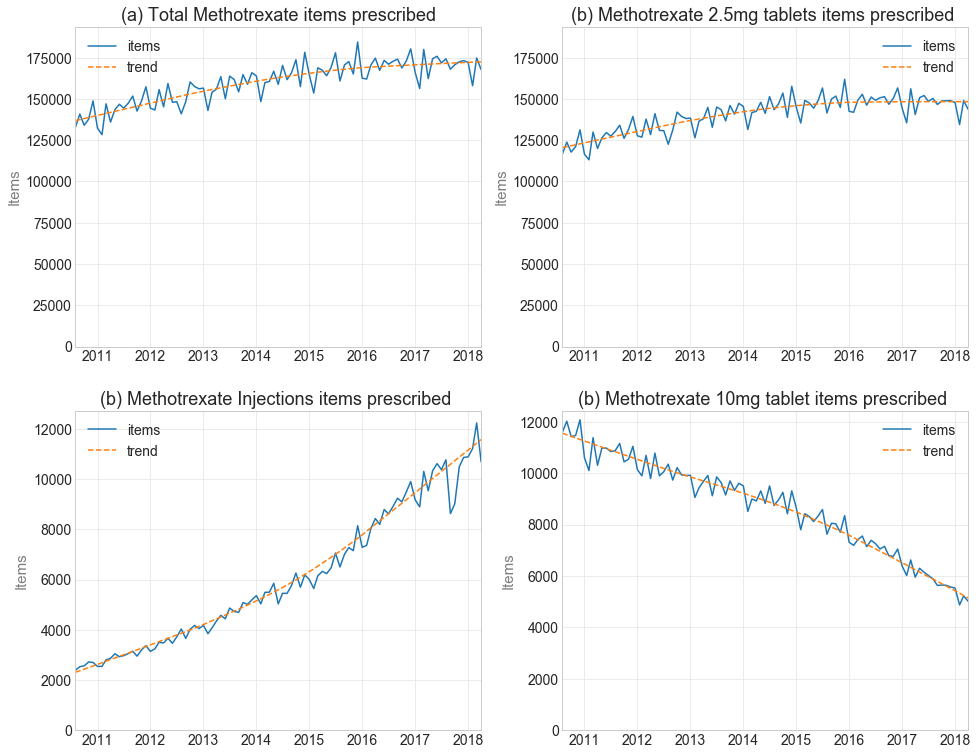

In [96]:
# total items in standard practices = 4

sns.set_style("whitegrid",{'grid.color': '.9'})
dfp = gp_mtx.sort_values(by=["month"])#,"drug"])
dfp['month_str'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month_str']]

fig = plt.figure(figsize=(16,20)) 
gs = gridspec.GridSpec(3,2)  # grid layout for subplots


# for smoothing, dataframe needs to be non-missing and have a DateTime index
data = gp_mtx.groupby('month').sum()[['total_mtxitems','list_size']]
data = pd.DataFrame(data['total_mtxitems'])
data['total_mtxitems'] = data["total_mtxitems"]

calc = decompose(data, period=12, lo_frac=0.6, lo_delta=0.0)
average = data.sum()/ (len(data))
flat = ((data-calc.trend))#/data)*100
#total items
ax = plt.subplot(gs[0,0])
ax.plot(data,label='items')
ax.plot(calc.trend,'--',label='trend')
ax.set_ylabel('Items', size =15, alpha=0.6)
ax.set_title('(a) Total Methotrexate items prescribed',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
max_value = data["total_mtxitems"].max()*1.05
ax.set_ylim([0,max_value])
ax.legend(prop={'size': 14})
std_t = data
#2.5mg tabs
ax = plt.subplot(gs[0,1])
data = gp_mtx.groupby('month').sum()[['mtx_2_5', 'list_size']]
data = pd.DataFrame(data['mtx_2_5'])

calc = decompose(data, period=12, lo_frac=0.6, lo_delta=0.0)
average = data.sum()/ (len(data))
flat = ((data-calc.trend))

ax.plot(data,label='items')
ax.plot(calc.trend,'--',label='trend')
ax.set_ylabel('Items', size =15, alpha=0.6)
ax.set_title('(b) Methotrexate 2.5mg tablets items prescribed ',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
ax.set_ylim([0,max_value])
ax.legend(prop={'size': 14})
std_ceph = data

#injections
ax = plt.subplot(gs[1,0])
data = gp_mtx.groupby('month').sum()[['mtx_inj','list_size']]
data = pd.DataFrame(data['mtx_inj'])

calc = decompose(data, period=12, lo_frac=0.6, lo_delta=0.0)
average = data.sum()/ (len(data))
flat = ((data-calc.trend))

ax.plot(data,label='items')
ax.plot(calc.trend,'--',label='trend')
ax.set_ylabel('Items', size =15, alpha=0.6)
ax.set_title('(b) Methotrexate Injections items prescribed ',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
ax.set_ylim(ymin=0)
ax.legend(prop={'size': 14})
std_ceph = data

#10mg tablets
ax = plt.subplot(gs[1,1])
data = gp_mtx.groupby('month').sum()[['mtx_10','list_size']]
data = pd.DataFrame(data['mtx_10'])

calc = decompose(data, period=12, lo_frac=0.6, lo_delta=0.0)
average = data.sum()/ (len(data))
flat = ((data-calc.trend))

ax.plot(data,label='items')
ax.plot(calc.trend,'--',label='trend')
ax.set_ylabel('Items', size =15, alpha=0.6)
ax.set_title('(b) Methotrexate 10mg tablet items prescribed ',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
ax.set_ylim(ymin=0)
ax.legend(prop={'size': 14})
std_ceph = data

plt.show()

## CCG level

In [94]:
# group to CCGs
pc_ccg = gp_mtx.groupby(['pct','month'],as_index=False).sum()

pc_ccg["2.5mg tabs"] = 100*(pc_ccg.mtx_2_5/pc_ccg.total_mtxitems).fillna(0)
pc_ccg["10mg tabs"] = 100*(pc_ccg.mtx_10/pc_ccg.total_mtxitems).fillna(0)
pc_ccg["liquid"] = 100*(pc_ccg.mtx_liq/pc_ccg.total_mtxitems).fillna(0)
pc_ccg["liquid specials"] = 100*(pc_ccg.mtx_liqspec/pc.total_mtxitems).fillna(0)
pc_ccg["injections"] = 100*(pc_ccg.mtx_inj/pc_ccg.total_mtxitems).fillna(0)

pc_ccg = pc_ccg.groupby('month').quantile(x)
pc_ccg = pc_ccg.reset_index().rename(columns={"level_1": 'percentile'})

pc_ccg.head(9)

,month,percentile,10mg tabs,2.5mg tabs,injections,liquid,liquid specials,list_size,mtx_10,mtx_2_5,mtx_inj,mtx_liq,mtx_liqspec,setting,total_mtxitems
0,2010-08-01,0.1,0.201982,66.756272,0.000000,0.0,0.0,0.0,1.0,17.0,0.0,0.0,0.0,8.0,22.5
1,2010-08-01,0.2,0.656814,77.824268,0.000000,0.0,0.0,0.0,2.0,229.0,0.0,0.0,0.0,64.0,268.0
2,2010-08-01,0.3,1.328192,85.467714,0.123212,0.0,0.0,0.0,6.0,302.5,1.0,0.0,0.0,88.0,355.5
3,2010-08-01,0.4,3.217158,89.278752,0.271739,0.0,0.0,0.0,11.0,366.0,1.0,0.0,0.0,108.0,430.0
4,2010-08-01,0.5,4.821919,92.188936,0.448433,0.0,0.0,0.0,18.0,419.5,2.0,0.0,0.0,124.0,477.5
5,2010-08-01,0.6,7.209302,94.032550,0.663350,0.0,0.0,0.0,27.0,497.0,3.0,0.0,0.0,144.0,552.0
6,2010-08-01,0.7,10.848762,96.096415,1.025857,0.0,0.0,0.0,43.0,591.0,5.0,0.0,0.0,170.0,655.5
7,2010-08-01,0.8,17.469880,98.036007,1.673640,0.0,0.0,0.0,68.0,773.0,10.0,0.0,1.0,200.0,843.0
8,2010-08-01,0.9,28.801843,99.052461,3.752470,0.0,0.0,0.0,118.0,1035.0,20.5,0.0,1.0,240.0,1175.0


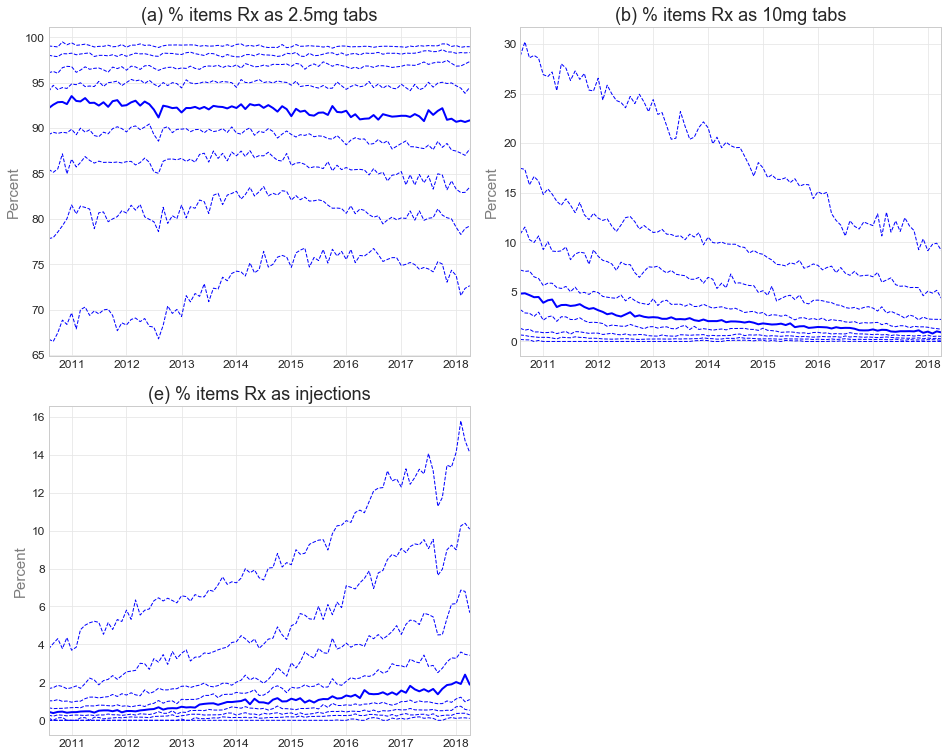

In [95]:
dfp = pc_ccg.sort_values(by=["month"])#,"drug"])
dfp['month'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month']]
x = pd.Series(x)

# set sort order of drugs manually, and add grid refs to position each subplot:
s = s = [(0,'2.5mg tabs',0,0,'(a) % items Rx as 2.5mg tabs','Percent'), 
     (1,'10mg tabs',0,1,'(b) % items Rx as 10mg tabs','Percent'),
     (2,'injections',1,0, '(e) % items Rx as injections', 'Percent')]
x = pd.Series(x)

fig = plt.figure(figsize=(16,20)) 
gs = gridspec.GridSpec(3,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    for decile in x:   # plot each decile line
        data = dfp.loc[(dfp['percentile']==decile)]#(dfp['drug']==i[1]) & 
        if decile == .5:
            ax.plot(data["dates"],data[i[1]],'b-',linewidth=2)
        elif (decile <0.1) | (decile >0.9):
            ax.plot(data["dates"],data[i[1]],'b:',linewidth=0.6)
        else:
            #print (data)
            ax.plot(data["dates"],data[i[1]],'b--',linewidth=1)
    ax.set_ylabel(i[5], size =15, alpha=0.6)
    ax.set_title(i[4],size = 18)
    #ax.set_ylim([0, dfp[i[1]].max()*1.05])  # set ymax across all subplots as largest value across dataset
    ax.tick_params(labelsize=12)
    ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range

plt.subplots_adjust(wspace = 0.12,hspace = 0.15)
#plt.savefig('ccg_deciles.png', format='png', dpi=300,bbox_inches='tight')

plt.show()

# MAPS

In [112]:
#aggregate over last year
ccg_last_year = gp_mtx.groupby(['pct','month'],as_index=False).sum()
ccg_last_year = ccg_last_year.loc[ccg_last_year["month"] >'2017-06-01']


#ccg_last_year = all_mtx_ccg.loc[all_mtx_ccg.month]
ccg_last_year = ccg_last_year.groupby('pct').sum()
ccg_last_year["list_size"] = ccg_last_year["list_size"]/12

ccg_last_year["2.5mg tabs"] = 100*(ccg_last_year.mtx_2_5/ccg_last_year.total_mtxitems).fillna(0)
ccg_last_year["10mg tabs"] = 100*(ccg_last_year.mtx_10/ccg_last_year.total_mtxitems).fillna(0)
ccg_last_year["injections"] = 100*(ccg_last_year.mtx_inj/ccg_last_year.total_mtxitems).fillna(0)
ccg_last_year["total_mtx_items"] = (ccg_last_year.total_mtxitems)/ccg_last_year["list_size"].fillna(0)

ccg_last_year.head()

,list_size,setting,mtx_2_5,mtx_10,mtx_liq,mtx_liqspec,mtx_inj,total_mtxitems,2.5mg tabs,10mg tabs,injections,total_mtx_items
pct,,,,,,,,,,,,
00C,90141.333333,440,3215,0,0,0,7,3237,99.320358,0.000000,0.216250,0.035910
00D,242924.416667,1516,8427,1,0,0,54,8499,99.152842,0.011766,0.635369,0.034986
00J,215189.916667,1240,7832,0,11,0,89,7966,98.317851,0.000000,1.117248,0.037018
00K,238809.833333,1248,5644,91,0,0,3,5739,98.344659,1.585642,0.052274,0.024032
00L,268252.666667,1692,10487,19,0,0,8,10583,99.092885,0.179533,0.075593,0.039452


In [113]:
# join to geographical data
map_data = ccg_last_year.reset_index()
names = pd.read_csv('ccg_for_map.csv')
names = names.rename(columns={"CCG17CDH":"code","CCG17NM":"name"})
map_data = map_data.merge(names[['code','name']],left_on="pct",right_on="code")
map_data['name'] = map_data['name'].str.upper()
map_data['name'] = map_data["name"].str.replace("&","AND")
map_data = map_data.set_index('name')
#map_data = map_data.round(0)
map_data.head() # 207 rows

,pct,list_size,setting,mtx_2_5,mtx_10,mtx_liq,mtx_liqspec,mtx_inj,total_mtxitems,2.5mg tabs,10mg tabs,injections,total_mtx_items,code
name,,,,,,,,,,,,,,
NHS DARLINGTON CCG,00C,90141.333333,440,3215,0,0,0,7,3237,99.320358,0.000000,0.216250,0.035910,00C
"NHS DURHAM DALES, EASINGTON AND SEDGEFIELD CCG",00D,242924.416667,1516,8427,1,0,0,54,8499,99.152842,0.011766,0.635369,0.034986,00D
NHS NORTH DURHAM CCG,00J,215189.916667,1240,7832,0,11,0,89,7966,98.317851,0.000000,1.117248,0.037018,00J
NHS HARTLEPOOL AND STOCKTON-ON-TEES CCG,00K,238809.833333,1248,5644,91,0,0,3,5739,98.344659,1.585642,0.052274,0.024032,00K
NHS NORTHUMBERLAND CCG,00L,268252.666667,1692,10487,19,0,0,8,10583,99.092885,0.179533,0.075593,0.039452,00L


C:\Users\bmackenna\Anaconda3\lib\site-packages\matplotlib\colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


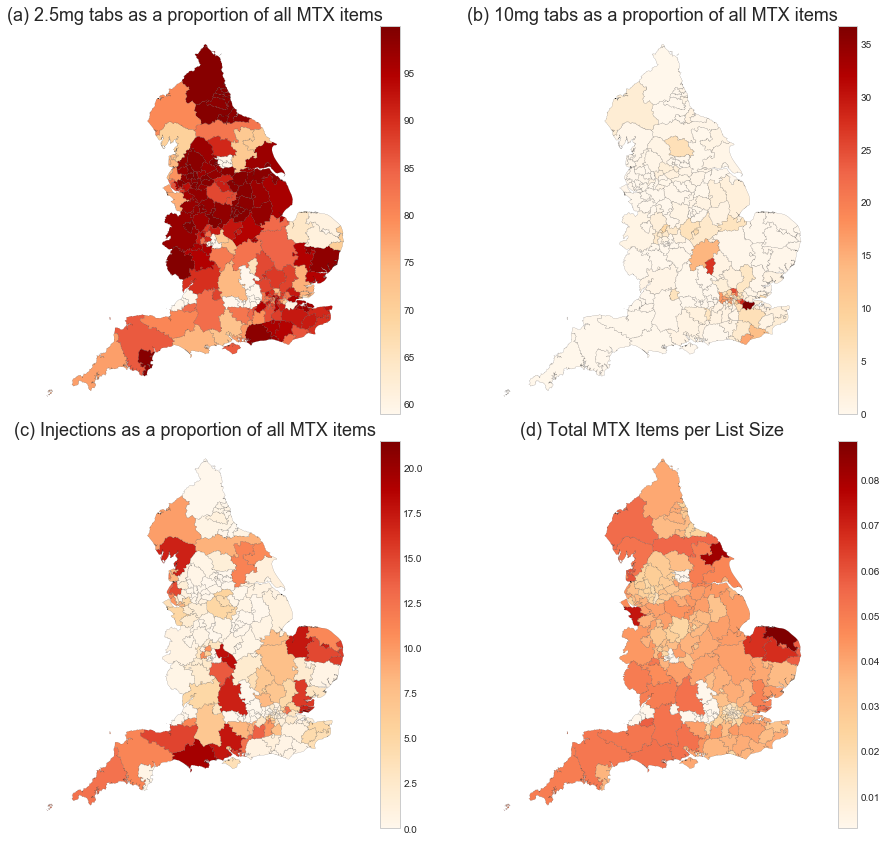

In [115]:
# from our API https://openprescribing.net/api/1.0/org_location/?org_type=ccg
ccgs = gpd.read_file('ccgs.json').set_index('name')

ccgs = ccgs[~ccgs['geometry'].isnull()]  # remove ones without geometry - these are federations rather than individual CCGs
gdf = ccgs.join(map_data)

# set sort order of measures manually, and add grid refs to position each subplot:
s = [(0,'2.5mg tabs',0,0,'(a) 2.5mg tabs as a proportion of all MTX items'), 
     (1,'10mg tabs',0,1,'(b) 10mg tabs as a proportion of all MTX items'),
     (2,'injections',1,0,'(c) Injections as a proportion of all MTX items'),
     (3,'total_mtx_items',1,1, '(d) Total MTX Items per List Size')]

fig = plt.figure(figsize=(16,30))
gs = gridspec.GridSpec(4,2)  # grid layout for subplots

for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    gdf.plot(ax=ax,column=i[1],  edgecolor='black', linewidth=0.1, legend=True, cmap='OrRd')
    ax.set_aspect(1.63)
    ax.set_title(i[4],size = 18)
    plt.axis('off')

plt.subplots_adjust(wspace = 0.05,hspace = 0.07)
plt.savefig('maps.png', format='png', dpi=300,bbox_inches='tight')

plt.show()

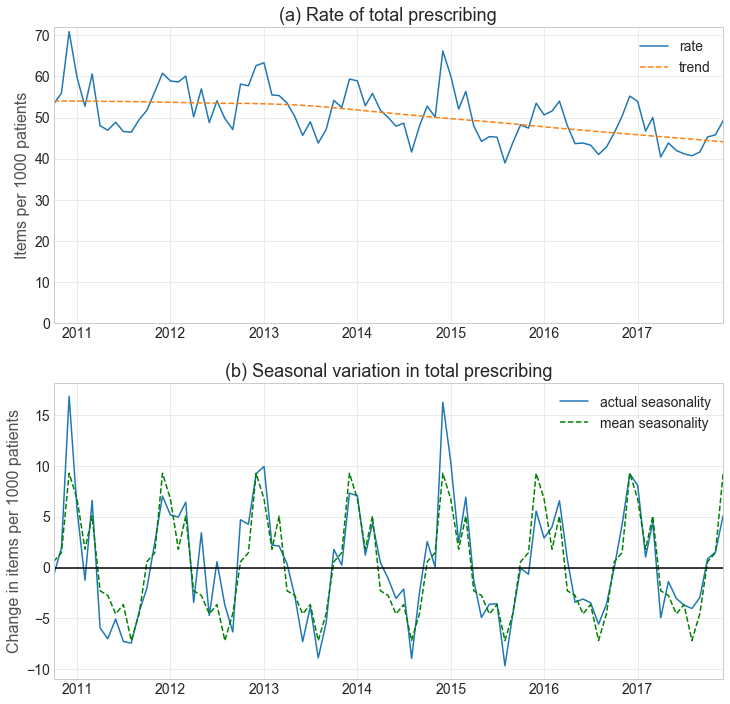

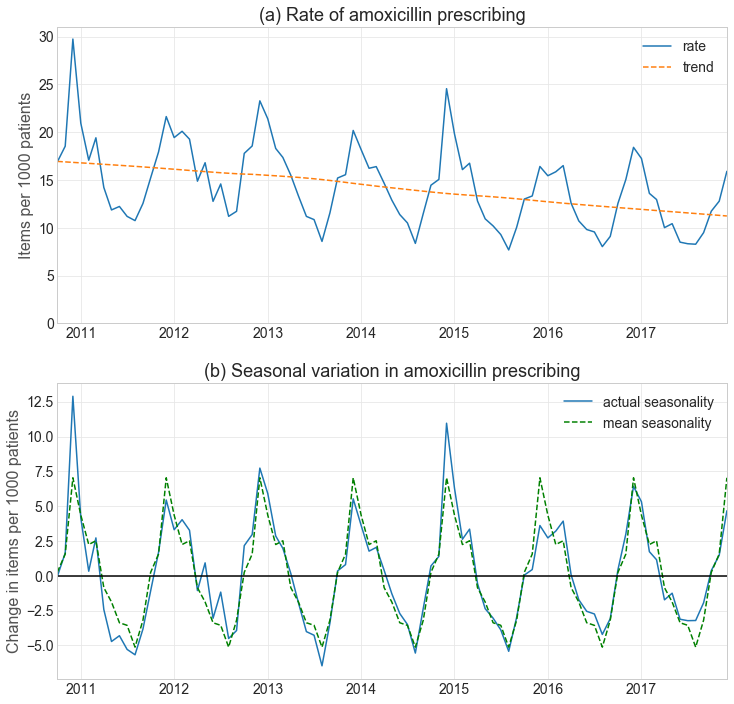

Typical amoxicillin seasonal variation 12.2 per 1000 patients


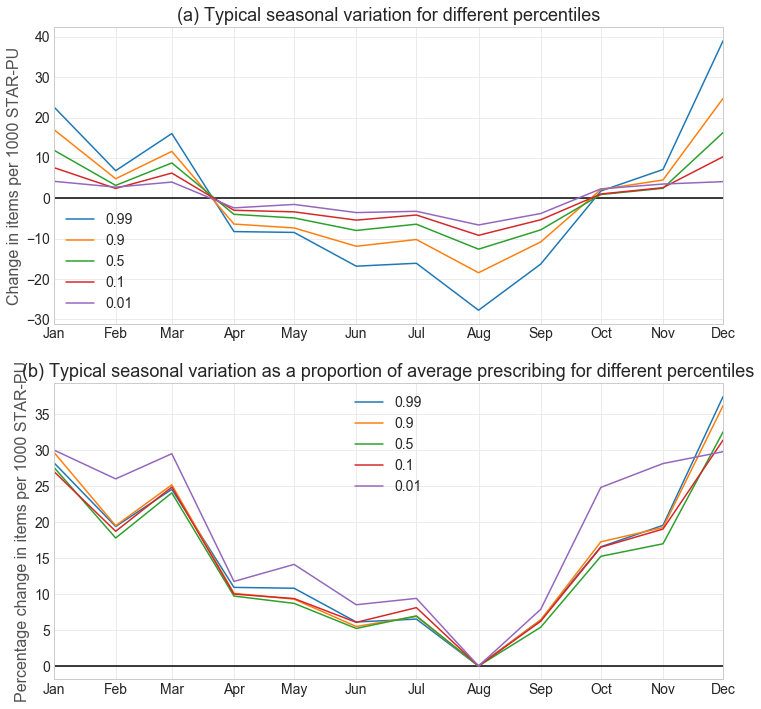

In [23]:
sns.set_style("whitegrid",{'grid.color': '.9'})
dfp = pcf.copy().sort_values(by=["month"])#,"drug"])
dfp['month_str'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month_str']]


'''fig = plt.figure(figsize=(16,35)) 
gs = gridspec.GridSpec(5,1)  # grid layout for subplots

for i in s:
#for decile in [0.01,0.1,0.5,0.9,0.99]:
    ax = plt.subplot(gs[i[2], i[3]])
    print(dfp['percentile'])
    print(i[4])
    data = dfp.loc[(round(dfp['percentile'],2)==i[4])]
    #data.info()
    # for smoothing, dataframe needs to be non-missing and have a DateTime index
    #data = data.dropna()
    data = data.set_index('month')


    calc = decompose(data[i[1]], period=12, lo_frac=0.6, lo_delta=0.0)
    #calc.plot()
    #plt.show()

    average = data.items_per_starpu.sum()/ (len(data.items_per_starpu))
    calc.seasonal = (calc.seasonal/average)*100
    flat = ((data.items_per_starpu-calc.trend)/data.items_per_starpu)*100
    #if decile == .5:
    #    ax.plot(data["dates"],res,'b-',linewidth=2)


    ax.plot(flat,label='actual seasonality')
    ax.plot(calc.seasonal,label='mean seasonality')
    ax.set_ylabel('Percentage change', size =16, alpha=0.8)
    ax.set_title('Percentile: %s'%(i[4]),size = 18)
    ax.tick_params(labelsize=14)
    ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
    ax.set_ylim([-30,30])
    ax.legend(prop={'size': 14})


plt.show()'''
fig = plt.figure(figsize=(12,12)) 
gs = gridspec.GridSpec(2,1)  # grid layout for subplots


# for smoothing, dataframe needs to be non-missing and have a DateTime index
#data = data.dropna()
data = all_antibiotics.loc[all_antibiotics["month"]>"2010-09-01"]
data = data.groupby('month').sum()[['items','list_size']]
data = pd.DataFrame(data['items']/(data.list_size/1000))

calc = decompose(data, period=12, lo_frac=0.6, lo_delta=0.0)
average = data.sum()/ (len(data))
#calc.seasonal = (calc.seasonal/average)*100
flat = ((data-calc.trend))#/data)*100

ax = plt.subplot(gs[0,0])
ax.plot(data,label='rate')
ax.plot(calc.trend,'--',label='trend')
ax.set_ylabel('Items per 1000 patients', size =16, alpha=0.8)
ax.set_title('(a) Rate of total prescribing',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
ax.set_ylim([0,72])
ax.legend(prop={'size': 14})

ax = plt.subplot(gs[1,0])
ax.plot(flat,label='actual seasonality')
ax.plot(calc.seasonal,'g--',label='mean seasonality')
ax.axhline(0,color='black')
ax.set_ylabel('Change in items per 1000 patients', size =16, alpha=0.8)
ax.set_title('(b) Seasonal variation in total prescribing',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
#ax.set_ylim([0,0.035])
ax.legend(prop={'size': 14})
plt.savefig('seasonal_variation_total.png', format='png', dpi=300,bbox_inches='tight')
plt.show()


fig = plt.figure(figsize=(12,12)) 
gs = gridspec.GridSpec(2,1)  # grid layout for subplots


# for smoothing, dataframe needs to be non-missing and have a DateTime index
#data = data.dropna()
data = all_antibiotics.loc[all_antibiotics["month"]>"2010-09-01"]
data = data.groupby('month').sum()[['amoxicillin','list_size']]
data = pd.DataFrame(data.amoxicillin/(data.list_size/1000))

calc = decompose(data, period=12, lo_frac=0.6, lo_delta=0.0)
average = data.sum()/ (len(data))
#calc.seasonal = (calc.seasonal/average)*100
flat = ((data-calc.trend))#/data)*100

ax = plt.subplot(gs[0,0])
ax.plot(data,label='rate')
ax.plot(calc.trend,'--',label='trend')
ax.set_ylabel('Items per 1000 patients', size =16, alpha=0.8)
ax.set_title('(a) Rate of amoxicillin prescribing',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
ax.set_ylim([0,31])
ax.legend(prop={'size': 14})

ax = plt.subplot(gs[1,0])
ax.plot(flat,label='actual seasonality')
ax.plot(calc.seasonal,'g--',label='mean seasonality')
ax.axhline(0,color='black')
ax.set_ylabel('Change in items per 1000 patients', size =16, alpha=0.8)
ax.set_title('(b) Seasonal variation in amoxicillin prescribing',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
#ax.set_ylim([0,0.035])
ax.legend(prop={'size': 14})
plt.show()
print("Typical amoxicillin seasonal variation %s per 1000 patients"%(round(calc.seasonal[0].max()-calc.seasonal[0].min(),1)))

s = [(0,'items_per_starpu',0,0,0.99),
     (1,'items_per_starpu',1,0,0.9),
     (2,'items_per_starpu',2,0,0.5),
     (3,'items_per_starpu',3,0,0.1),
     (4,'items_per_starpu',4,0,0.01)]
fig = plt.figure(figsize=(12,12)) 
gs = gridspec.GridSpec(2,1)  # grid layout for subplots
ax = plt.subplot(gs[0,0])
ax.axhline(0,color='black')
ax2 = plt.subplot(gs[1,0])
ax2.axhline(0,color='black')
for i in s:
    data = dfp.loc[(round(dfp['percentile'],2)==i[4])]
    # for smoothing, dataframe needs to be non-missing and have a DateTime index
    #data = data.dropna()
    data = data.set_index('month')
    calc = decompose(data[i[1]], period=12, lo_frac=0.6, lo_delta=0.0)
    august = pd.DataFrame(data.items_per_starpu.reset_index().loc[pd.DatetimeIndex(data.reset_index()['month']).month==8])
    #average = august.sum() / (len(august))
    #average = average.items_per_starpu
    average = data.items_per_starpu.sum()/ (len(data.items_per_starpu))
    minimum = calc.seasonal.min()
    
    ax.plot(calc.seasonal,label=i[4])
    ax.set_ylabel('Change in items per 1000 STAR-PU', size =16, alpha=0.8)
    ax.set_title('(a) Typical seasonal variation for different percentiles',size = 18)
    ax.tick_params(labelsize=14)
    ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
    #ax.set_ylim([-20,25])
    ax.legend(prop={'size': 14})
    ax.set_xlim(['2017-01-01', dfp['dates'].max()]) # set x axis range as full date range
    bins = np.arange(1,14)
    ax.set_xticklabels([datetime.date(1900,i,1).strftime('%b') for i in bins[:-1]])
    
    calc.seasonal = ((calc.seasonal-minimum) / average) * 100
    
    ax2.plot(calc.seasonal,label=i[4])
    ax2.set_ylabel('Percentage change in items per 1000 STAR-PU', size =16, alpha=0.8)
    ax2.set_title('(b) Typical seasonal variation as a proportion of average prescribing for different percentiles',size = 18)
    ax2.tick_params(labelsize=14)
    ax2.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
    #ax2.set_ylim([-20,25])
    ax2.legend(prop={'size': 14})
    ax2.set_xlim(['2017-01-01', dfp['dates'].max()]) # set x axis range as full date range
    bins = np.arange(1,14)
    ax2.set_xticklabels([datetime.date(1900,i,1).strftime('%b') for i in bins[:-1]])
plt.show()

In [23]:
# practice-level data restricted to those with >1000 patients
qdf = all_antibiotics.copy()
qdf = qdf.loc[(qdf.list_size>1000) & (~pd.isnull(qdf.star_pu_items)) & (qdf["month"]>"2010-09-01") ]

# Assign months to seasons - use numbers so that decomposition function can recognise them as dates.
import datetime as dt
qdf["monthno"] = qdf.month.dt.month # extract month as a number
qdf["year"] = qdf.month.dt.year.astype(int)

conditions = [
    (qdf['monthno']<=2 ),
    (qdf['monthno']<=5 ),
    (qdf['monthno']<=8 ),
    (qdf['monthno']<=11 )]
choices = [("01"),("04"),("07"),("10")]
qdf['season'] = np.select(conditions, choices, default="01")
qdf["season_yr"]= np.where(qdf["monthno"]==1, qdf["year"]-1,qdf["year"])
#qdf['dates'] = qdf["season_yr"].astype(str)+"-"+qdf["season"]+"-"+"01"
qdf = qdf.loc[(qdf["season"]!="04") & (qdf["season"]!="10") & (qdf["season_yr"]!=2010)]
qdf = qdf.drop(["monthno","setting"],axis=1)

# group data by season
qdf = qdf.groupby(["season_yr","season","practice"]).mean()
qdf = qdf.drop(["all_broad_spectrum","denom_broad_spectrum","numerator_uti_course","denominator_uti_course"],axis=1)

# calculate prescribing rate per 1,000 STAR-PU & rearrange data:
qdf["items_per_starpu"] = 1000*qdf["items"]/qdf["star_pu_items"]
qdf["amox_per_starpu"] = 1000*qdf["amoxicillin"]/qdf["star_pu_items"]
qdf["fluc_per_starpu"] = 1000*qdf["flucloxacillin"]/qdf["star_pu_items"]

# make a separate table for fluc & amox:
qdfa = qdf.reset_index()[["practice","season_yr","season","amox_per_starpu","fluc_per_starpu"]]

# rearrange data
qdf = qdf.reset_index()[["practice","season_yr","season","items_per_starpu"]]
qdf = qdf.groupby(["practice","season_yr","season"]).mean().unstack().reset_index(col_level=1)
qdf.columns = qdf.columns.droplevel()

# exclude practices for any year in which they do not have data for both seasons:
qdf = qdf.loc[(pd.notnull(qdf["01"])) & (pd.notnull(qdf["07"]))] 
# assign practices to deciles for summer period; find their absolute increase in prescribing rate in winter:
qdf["decile_summer"] = qdf.groupby(["season_yr"])["07"].rank(pct=True)
qdf["decile_summer"] = np.floor(qdf["decile_summer"]*10-0.00000001).astype(int)
qdf["winterpeak_abs"] = qdf["01"]-qdf["07"]

# find mean increase for each decile, then tranlsate to percentage
qdf = qdf.groupby(["decile_summer","season_yr"]).mean().reset_index()
qdf["winterpeak (%)"] = 100*qdf["winterpeak_abs"]/qdf["07"]

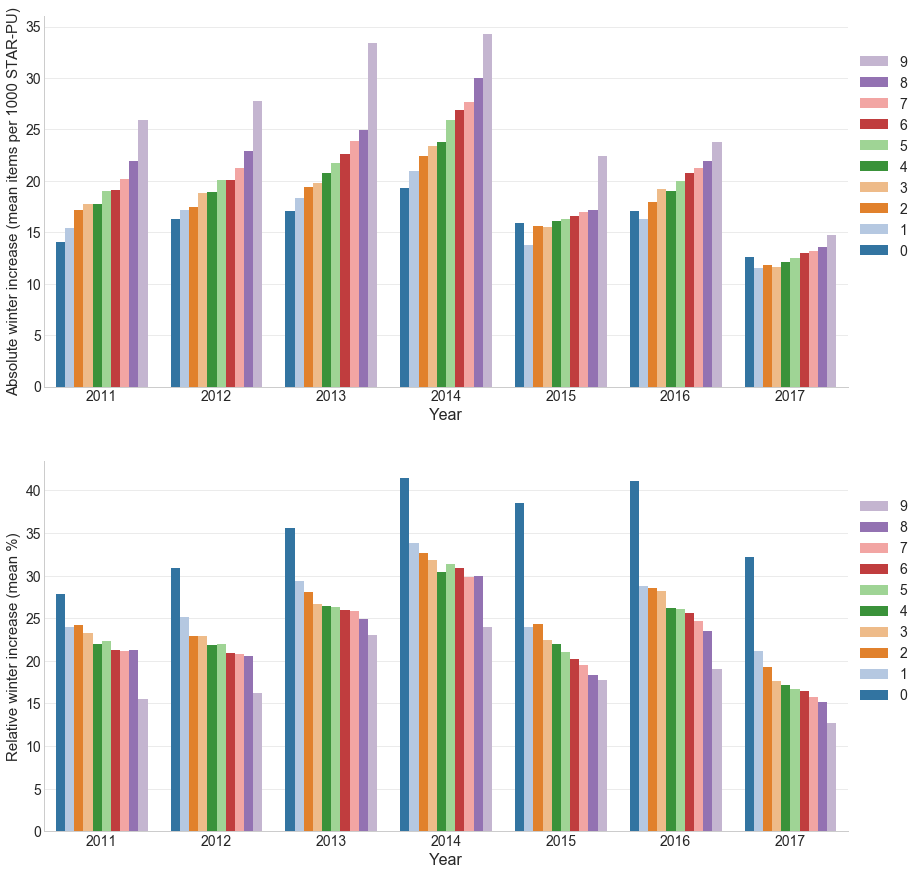

In [24]:
dfp = qdf[["season_yr","decile_summer","winterpeak_abs","winterpeak (%)"]].sort_values(by=["season_yr","decile_summer"])
data = dfp.copy()

fig = plt.figure(figsize=(16,15)) 
gs = gridspec.GridSpec(2,1)  # grid layout for subplots

s = [(0,'winterpeak_abs',"Absolute winter increase (mean items per 1000 STAR-PU)"),
     (1,'winterpeak (%)',"Relative winter increase (mean %)")]

for i in s:
    ax = plt.subplot(gs[i[0],0])
    sns.barplot(x="season_yr", y=i[1], hue="decile_summer", data=data, palette="tab20", ax=ax)

    ax.set_ylabel(i[2],size=15)
    ax.set_xlabel("Year",size=16)
    ax.tick_params(labelsize=14)

    sns.despine(ax=ax, right=True, left=False)

    handles, labels = ax.get_legend_handles_labels()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
    ax.legend(reversed(handles), reversed(labels),loc='center left', fontsize="14",bbox_to_anchor=(1, .62))
    
plt.show()

# Merge data for regression model (see Stata code)

In [25]:
last_year = all_antibiotics.loc[(all_antibiotics.list_size>1000) & (~pd.isnull(all_antibiotics.list_size)) & (all_antibiotics["month"]>="2017-01-01")]
last_year = last_year[['practice','pct','items','list_size']]
last_year = last_year.groupby(['practice','pct'],as_index=False).agg({'items':'sum','list_size':'mean'})
last_year['rate'] = last_year['items'] / (last_year['list_size'] / 1000)
last_year['monthly_rate'] = last_year['rate']/12
last_year = last_year[['practice','pct','items','rate','monthly_rate']]
last_year.rate.quantile([0.1,0.5,0.9])

0.1    331.058519
0.5    539.316533
0.9    707.395047
Name: rate, dtype: float64

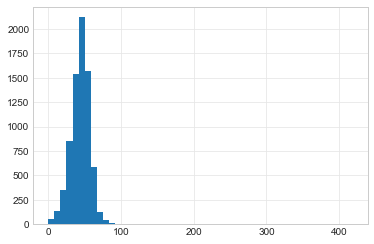

In [26]:
last_year.monthly_rate.hist(bins=50)
plt.show()

C:\Users\Alex\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (9,10,11,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


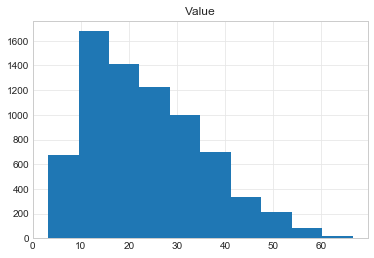

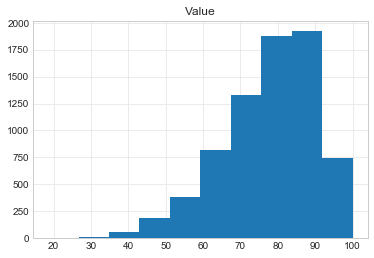

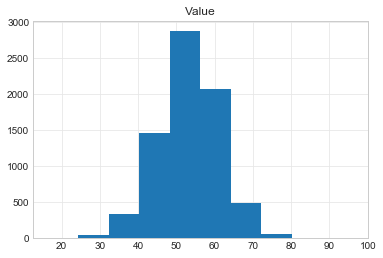

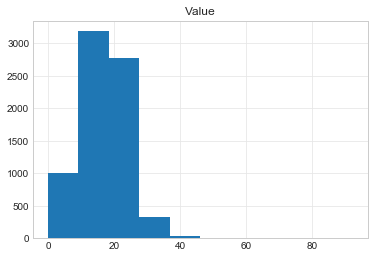

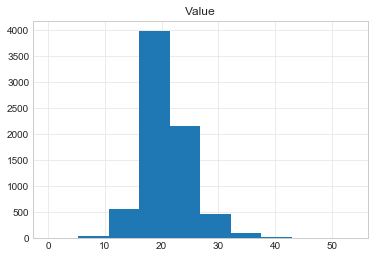

In [27]:
phe = pd.read_csv('indicators-GP.data.csv')

mask = (phe['Indicator Name'] == 'Deprivation score (IMD 2015)') & (phe['Area Type'] == 'GP')
imd = phe.loc[mask, ['Area Code','Value']]
imd = imd.set_index('Area Code')
imd.hist()
plt.show()

mask = (phe['Indicator Name'] == '% who would recommend practice') & (phe['Area Type'] == 'GP') & (phe['Time period'] == '2015/16')
satisfaction = phe.loc[mask, ['Area Code','Value']]
satisfaction = satisfaction.set_index('Area Code')
satisfaction.hist()
plt.show()

mask = (phe['Indicator Name'] == '% with a long-standing health condition') & (phe['Area Type'] == 'GP') & (phe['Time period'] == '2015/16')
long_term_health = phe.loc[mask, ['Area Code','Value']]
long_term_health = long_term_health.set_index('Area Code')
long_term_health.hist()
plt.show()

mask = (phe['Indicator Name'] == '% aged 65+ years') & (phe['Area Type'] == 'GP') & (phe['Time period'] == 2016)
over_65 = phe.loc[mask, ['Area Code','Value']]
over_65 = over_65.set_index('Area Code')
over_65.hist()
plt.show()

mask = (phe['Indicator Name'] == '% aged under 18 years') & (phe['Area Type'] == 'GP') & (phe['Time period'] == 2016)
under_18 = phe.loc[mask, ['Area Code','Value']]
under_18 = under_18.set_index('Area Code')
under_18.hist()
plt.show()

In [28]:
qof = pd.read_csv('ACHIEVEMENT_EXCEPTIONS.csv')
qof_map = pd.read_csv('INDICATOR_MAPPINGS.csv')
qof = qof.merge(qof_map[['INDICATOR_CODE','DOMAIN_CODE']], how='inner', on='INDICATOR_CODE', copy=False)
qof_all = qof.loc[qof.MEASURE == 'ACHIEVED_POINTS'].groupby(['PRACTICE_CODE','DOMAIN_CODE']).sum()
qof_all = qof_all.unstack(level=1) #.reset_index(col_level=0)
qof_all.columns = qof_all.columns.droplevel(0)
qof_all['TOTAL'] = qof_all['CL'] + qof_all['PH'] + qof_all['PHAS']
qof_all.head(10)

DOMAIN_CODE,CL,PH,PHAS,TOTAL
PRACTICE_CODE,,,,
A81001,425.69,97.00,24.0,546.69
A81002,435.00,97.00,27.0,559.00
A81003,425.34,97.00,27.0,549.34
A81004,427.63,97.00,27.0,551.63
A81005,429.72,91.76,27.0,548.48
A81006,425.72,97.00,27.0,549.72
A81007,430.68,97.00,27.0,554.68
A81008,428.28,97.00,27.0,552.28
A81009,434.00,87.00,27.0,548.00


In [29]:
q = '''
SELECT
  code,
  dispensing_patients
FROM
  ebmdatalab.bsa.dispensing_practices_jan2017
ORDER BY
  code ASC
'''
dispensing = pd.read_gbq(q, GBQ_PROJECT_ID, verbose=False)
dispensing.head(5)

,code,dispensing_patients
0,A81001,0
1,A81002,0
2,A81004,0
3,A81005,0
4,A81006,0


In [30]:
q = '''
SELECT
  practice,
  SUM(items) AS total_items
FROM
  ebmdatalab.hscic.normalised_prescribing_legacy
WHERE
  month >= TIMESTAMP("2016-07-01")
  AND month <= TIMESTAMP("2017-06-01")
GROUP BY
  practice
'''
precribing_volume = pd.read_gbq(q, GBQ_PROJECT_ID, verbose=False)
precribing_volume.head(5)

,practice,total_items
0,N81118,161013
1,N81010,138491
2,N81015,196770
3,N81623,50642
4,N81645,52827


In [31]:
q = '''
SELECT
  *
FROM
  ebmdatalab.ONS.practices_rural_urban
'''
urban_rural = pd.read_gbq(q, GBQ_PROJECT_ID, verbose=False)
urban_rural.head(5)

,code,rural_urban_code
0,A81001,4
1,A81002,4
2,A81003,4
3,A81004,4
4,A81005,3


In [32]:
q = '''
SELECT
  practice,
  --pct_id as pct,
  AVG(total_list_size) as list_size
FROM
  [ebmdatalab:hscic.practice_statistics]
WHERE
  month >= TIMESTAMP("2016-07-01")
  AND month <= TIMESTAMP("2017-06-01")
GROUP BY
  practice,
  --pct
ORDER BY
  practice
'''
list_size = pd.io.gbq.read_gbq(q, GBQ_PROJECT_ID, verbose=False)
list_size.head(5)

,practice,list_size
0,A81001,4196.333333
1,A81002,19940.750000
2,A81003,3287.000000
3,A81004,9252.666667
4,A81005,7923.750000


In [34]:
gps_per_practice = pd.read_csv('gps_per_practice_sept_2017.csv')
gps_per_practice

,practice,num_gps_june,num_gps_sept
0,A81001,2.0,NaN
1,A81002,12.0,12.0
2,A81004,2.0,3.0
3,A81005,8.0,9.0
4,A81006,8.0,8.0
5,A81007,9.0,10.0
6,A81009,5.0,5.0
7,A81011,5.0,5.0
8,A81012,2.0,2.0
9,A81013,4.0,4.0


In [35]:
measures = {'ktt9_cephalosporins':'Antibiotic stewardship: co-amoxiclav, cephalosporins &amp; quinolones (KTT9)',
            'ktt9_uti_antibiotics':'Antibiotic stewardship: three-day courses for uncomplicated UTIs (KTT9)',
            #'ktt9_antibiotics':'Antibiotic stewardship: volume of antibiotic prescribing (KTT9)',
            'ciclosporin':'Ciclosporin and tacrolimus oral preparations prescribed generically',
            'coproxamol':'Co-proxamol',
            'desogestrel':'Desogestrel prescribed as a branded product',
            'diltiazem':'Diltiazem preparations (>60mg) prescribed generically',
            #'doacs':'Direct Oral Anticoagulants (DOACs)',
            'quetiapine':'Extended-release quetiapine',
            'glaucoma':'Glaucoma eye drops prescribed by brand',
            'ace':'High-cost ACE inhibitors',
            'arb':'High-cost ARBs',
            'sildenafil':'High-cost drugs for erectile dysfunction',
            'ppi':'High-cost PPIs',
            'statins':'High-cost statins',
            'icsdose':'High dose inhaled corticosteroids',
            'opioidspercent':'High dose opioids as percentage regular opioids',
            'opioidper1000':'High dose opioids per 1000 patients',
            'ppidose':'Higher dose Proton Pump Inhibitors (PPIs)',
            'keppra':'Keppra vs. levetiracetam',
            'ktt12_diabetes_insulin':'Long-acting insulin analogues (KTT12)',
            'statinintensity':'Low and medium intensity statins',
            'methotrexate':'Methotrexate 10 mg tablets',
            'nebivolol':'Nebivolol 2.5mg tablets',
            'lpzomnibus':'NHS England Low Priority Treatment - All Low Priority Treatments',
            #'lpcoprox':'NHS England Low Priority Treatment - co-proxamol',
            #'lpdosulepin':'NHS England Low Priority Treatment - dosulepin',
            #'lpdoxazosin':'NHS England Low Priority Treatment - doxazosin modified release',
            #'lpfentanylir':'NHS England Low Priority Treatment - fentanyl immediate release',
            #'lpglucosamine':'NHS England Low Priority Treatment - glucosamine and chondroitin',
            #'lpglutenfree':'NHS England Low Priority Treatment - gluten free products',
            #'lphomeopathy':'NHS England Low Priority Treatment - homeopathy',
            #'lplidocaine':'NHS England Low Priority Treatment - lidocaine plasters',
            #'lpliothyronine':'NHS England Low Priority Treatment - liothyronine',
            #'lplutein':'NHS England Low Priority Treatment - lutein and antioxidants',
            #'lpomega3':'NHS England Low Priority Treatment - omega-3 fatty acid compounds',
            #'lpoxycodone':'NHS England Low Priority Treatment - oxycodone and naloxone combination product',
            #'lptramadolpara':'NHS England Low Priority Treatment - paracetamol and tramadol combination',
            #'lpperindopril':'NHS England Low Priority Treatment - perindopril arginine',
            #'lprubefacients':'NHS England Low Priority Treatment - rubefacients',
            #'lptadalafil':'NHS England Low Priority Treatment - tadalafil once daily',
            #'lptravelvacs':'NHS England Low Priority Treatment - travel vaccines',
            #'lptrimipramine':'NHS England Low Priority Treatment - trimipramine',
            'ktt13_nsaids_ibuprofen':'Non-preferred NSAIDs and COX-2 inhibitors (KTT13)',
            'ktt3_lipid_modifying_drugs':'Other lipid-modifying drugs (KTT3)',
            'lyrica':'Pregabalin prescribed as Lyrica',
            'dipyridamole':'Prescribing of dipyridamole',
            'tramadol':'Prescribing of high cost tramadol preparations ',
            #'pregabalin':'Prescribing of pregabalin',
            #'pregabalinmg':'Prescribing of pregabalin (total mg)',
            'trimethoprim':'Prescribing of trimethoprim vs nitrofurantoin',
            'saba':'Short acting beta agonist inhalers',
            'silver':'Silver dressings',
            'solublepara':'Soluble/effervescent forms of paracetamol and co-codamol',
            'fungal':'Topical treatment of fungal nail infections',
            'vitb':'Vitamin B complex'}

In [36]:
all_measures = []
for measure, label in measures.items():
    q = '''
    SELECT
      practice_id,
      AVG(percentile) as mean_percentile
    FROM
      ebmdatalab.measures.practice_data_%s
    WHERE
      month >= "2017-01-01"
      AND month <= "2017-12-01"
    GROUP BY
      practice_id
    ''' % (measure)

    df = pd.read_gbq(q, GBQ_PROJECT_ID, verbose=False, dialect='standard')
    df['measure'] = measure
    all_measures.append(df)
    del df
all_measures = pd.concat(all_measures)
all_measures.head()

,practice_id,mean_percentile,measure
0,A81003,NaN,ktt9_cephalosporins
1,A82011,NaN,ktt9_cephalosporins
2,A83068,NaN,ktt9_cephalosporins
3,A85601,NaN,ktt9_cephalosporins
4,A88024,NaN,ktt9_cephalosporins


In [37]:
all_measures

,practice_id,mean_percentile,measure
0,A81003,NaN,ktt9_cephalosporins
1,A82011,NaN,ktt9_cephalosporins
2,A83068,NaN,ktt9_cephalosporins
3,A85601,NaN,ktt9_cephalosporins
4,A88024,NaN,ktt9_cephalosporins
5,A89611,NaN,ktt9_cephalosporins
6,A89618,NaN,ktt9_cephalosporins
7,B81072,NaN,ktt9_cephalosporins
8,B82043,NaN,ktt9_cephalosporins
9,C81116,NaN,ktt9_cephalosporins


In [38]:
summ_measures = all_measures.groupby('practice_id').mean()
summ_measures.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8188 entries, A81001 to Y05857
Data columns (total 1 columns):
mean_percentile    7609 non-null float64
dtypes: float64(1)
memory usage: 127.9+ KB


In [39]:
# urban_rural
# qof_all.
# imd.
# satisfaction.
# long_term_health.
# over_65.
# dispensing.
# precribing_volume.

all = last_year.merge(urban_rural,
                how='left',
                left_on='practice',
                right_on='code',
                copy=False)

all = all.merge(summ_measures,
                how='left',
                left_on='practice',
                right_index=True,
                copy=False)

all = all.merge(gps_per_practice,
                how='left',
                on='practice',
                copy=False)

all = all.merge(qof_all,
                how='left',
                left_on='practice',
                right_index=True,
                copy=False)

all = all.merge(imd,
                how='left',
                left_on='practice',
                right_index=True,
                copy=False)
all = all.merge(satisfaction,
                how='left',
                left_on='practice',
                right_index=True,
                copy=False,
                suffixes=('_imd', ''))
all = all.merge(long_term_health,
                how='left',
                left_on='practice',
                right_index=True,
                copy=False,
                suffixes=('_satisfaction', ''))
all = all.merge(over_65,
                how='left',
                left_on='practice',
                right_index=True,
                copy=False,
                suffixes=('_long_term_health', ''))
all = all.merge(under_18,
                how='left',
                left_on='practice',
                right_index=True,
                copy=False,
                suffixes=('_over_65', '_under_18'))
all = all.merge(dispensing,
                how='left',
                left_on='practice',
                right_on='code',
                copy=False)
all = all.merge(precribing_volume,
                how='left',
                left_on='practice',
                right_on='practice',
                copy=False)

all.to_csv('antibiotics_for_analysis.csv')
all.describe()
all.head()

,practice,pct,items,rate,monthly_rate,code_x,rural_urban_code,mean_percentile,num_gps_june,num_gps_sept,...,PHAS,TOTAL,Value_imd,Value_satisfaction,Value_long_term_health,Value_over_65,Value_under_18,code_y,dispensing_patients,total_items
0,A81001,00K,2455,590.085128,49.173761,A81001,4,0.400916,2.0,NaN,...,24.0,546.69,29.140310,76.020488,57.895013,22.674829,19.722157,A81001,0.0,90945
1,A81002,00K,13413,672.482515,56.040210,A81002,4,0.463431,12.0,12.0,...,27.0,559.00,29.689706,85.166335,58.872464,21.025589,18.776949,A81002,0.0,455226
2,A81004,00M,5658,591.083601,49.256967,A81004,4,0.452342,2.0,3.0,...,27.0,551.63,34.411828,72.955168,50.053075,18.898240,18.135315,A81004,0.0,191940
3,A81005,00M,4791,602.067211,50.172268,A81005,3,0.351088,8.0,9.0,...,27.0,548.48,15.743812,85.118831,52.133158,26.626843,17.585155,A81005,0.0,196498
4,A81006,00K,9051,653.741746,54.478479,A81006,4,0.398237,8.0,8.0,...,27.0,549.72,31.791515,85.096769,51.838239,18.484408,20.861205,A81006,0.0,321726
